In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import numpy as np
import re

import seaborn as sns

39


<AxesSubplot: xlabel='Y', ylabel='X'>

/home/gero/Projects/san-francisco-crime/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/gero/Projects/san-francisco-crime/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


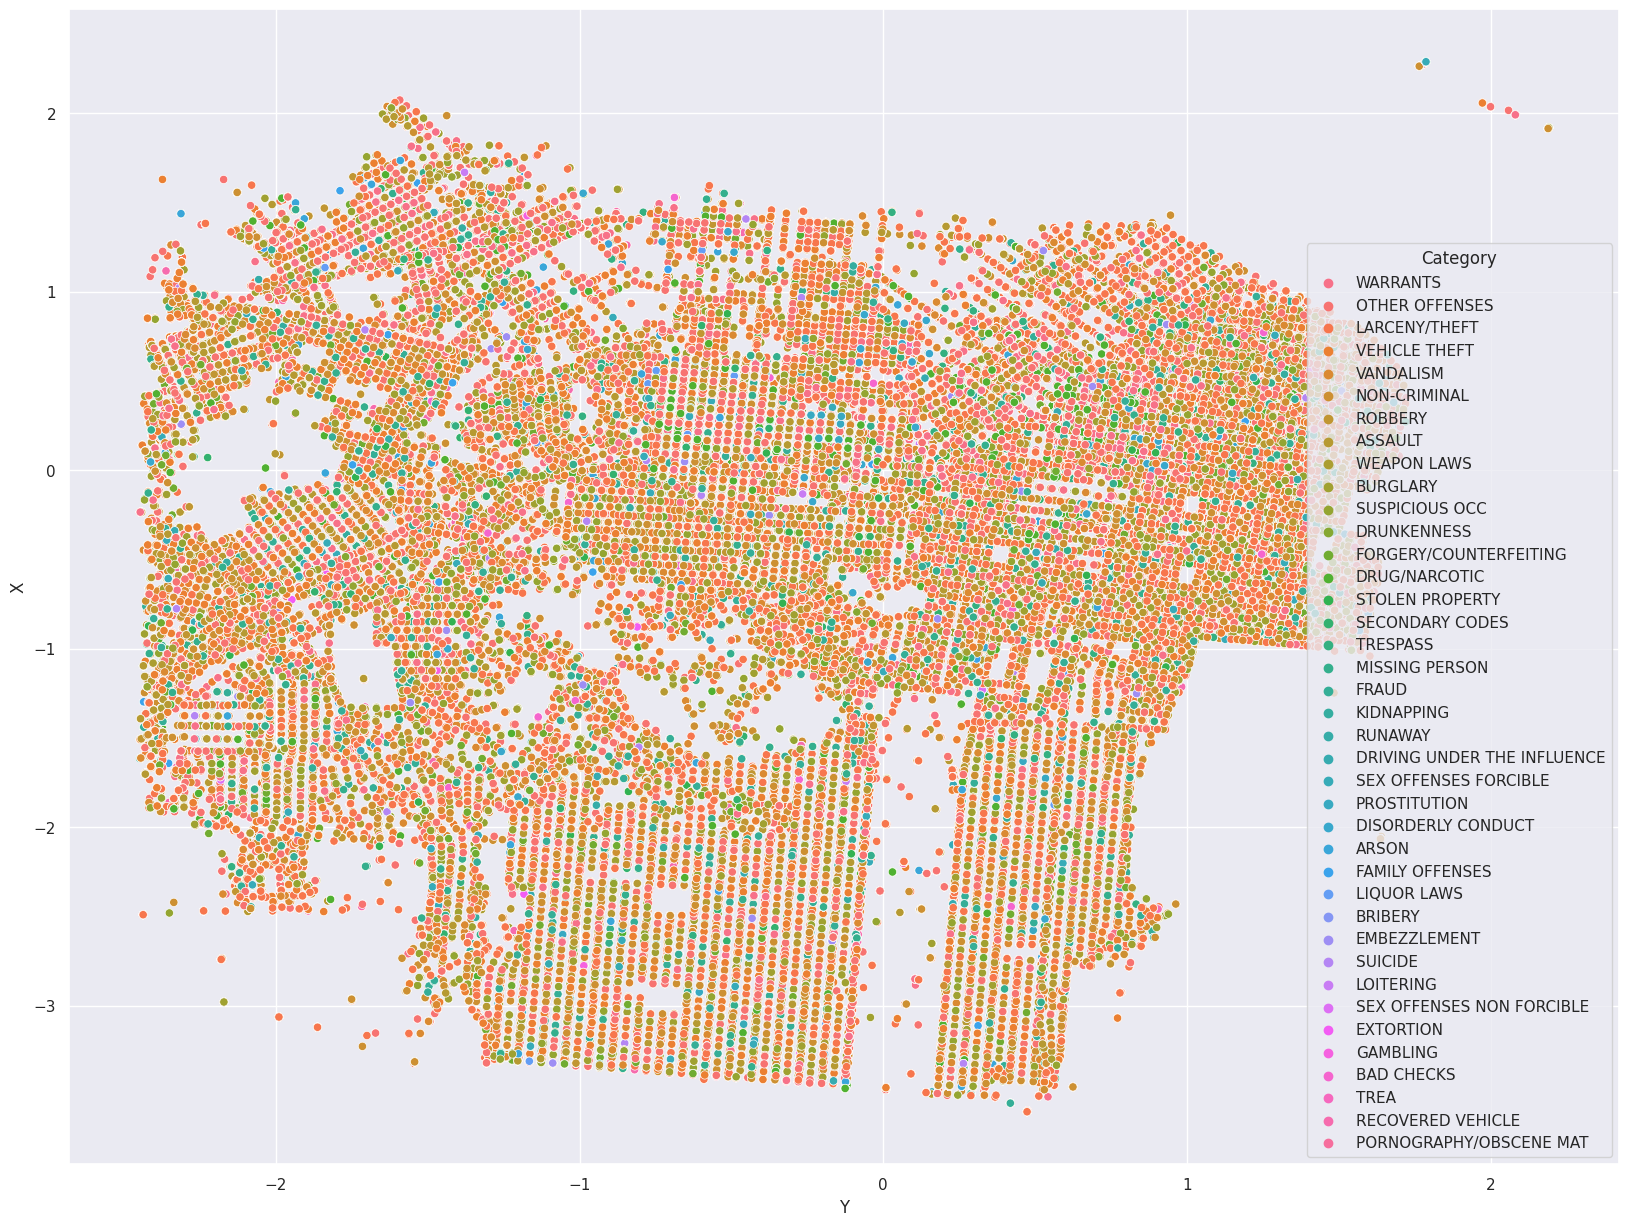

In [5]:
data = pd.read_csv('../data/train.csv')

# There seems to be invalid data that contains latitude = 90. (Which would be the North Pole)
data = data[data['Y'] != 90]
data = data[data['Category'] != 'NONE']

print(len(data['Category'].unique()))

standard_scaler = StandardScaler()
x = np.asarray(data['X']).reshape((-1, 1))
y = np.asarray(data['Y']).reshape((-1, 1))
data['X'] = StandardScaler().fit_transform(x)
data['Y'] = StandardScaler().fit_transform(y)

sns.set(rc={'figure.figsize': (20, 15)})
sns.scatterplot(data, x='Y', y='X', hue='Category')


In [4]:
data = pd.read_csv('../data/train.csv')

# There seems to be invalid data that contains latitude = 90. (Which would be the North Pole)
data = data[data['Y'] != 90]

y_train = data['Category']

# The description and category are not part of the test data, therefore we cannot use them for training.
# And we need to drop the resolution variable since it is our target variable and also not part of the test data.
x_train = data.drop(['Descript', 'Category', 'Resolution'], axis=1)

# TODO: Extract this into a function. ###
# Split the date into its subcomponents
x_train[['year', 'month', 'day', 'hour', 'minute']] = x_train.Dates.str.extract(
    '(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2}) (?P<hour>\d{2}):(?P<minute>\d{2})')

x_train["federal_holiday"] = "None"
x_train.loc[x_train['Dates'].str.match('\d{4}-01-01'), 'federal_holiday'] = 'new_year'
x_train.loc[x_train['Dates'].str.match('\d{4}-07-04'), 'federal_holiday'] = 'independence_day'
x_train.loc[x_train['Dates'].str.match('\d{4}-11-24'), 'federal_holiday'] = 'thanksgiving'
x_train.loc[x_train['Dates'].str.match('\d{4}-12-25'), 'federal_holiday'] = 'christmas_day'
x_train.loc[x_train['Dates'].str.match('\d{4}-12-26'), 'federal_holiday'] = 'christmas_day'
x_train.loc[x_train['Dates'].str.match('\d{4}-12-31'), 'federal_holiday'] = 'new_year'

x_train.drop(['Dates'], inplace=True, axis=1)

# Convert the date numbers into actual integers
x_train = x_train.astype({
    'year': 'float64',
    'month': 'float64',
    'day': 'float64',
    'hour': 'float64',
    'minute': 'float64',
})

# One-Hot encoding for the DayOfTheWeek
column_transformer = make_column_transformer(
    (OneHotEncoder(), ['DayOfWeek', 'PdDistrict']),
    (StandardScaler(), ['X', 'Y', 'year', 'month', 'day', 'hour', 'minute']),
    remainder='passthrough'
)

x_train_transformed = column_transformer.fit_transform(x_train)
x_train = pd.DataFrame(data=x_train_transformed, columns=column_transformer.get_feature_names_out())

x_train = x_train.rename(columns={element: re.sub(r'^(.+)__', '', element) for element in x_train.columns.tolist()})

x_train.to_csv('../data/x_train_cleaned.csv', index=False)
y_train.to_csv('../data/y_train_cleaned.csv', index=False)

x_train

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,X,Y,year,month,day,hour,minute,Address
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.123732,0.313018,1.731591,-0.418903,-0.292669,1.463812,1.766322,OAK ST / LAGUNA ST
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.123732,0.313018,1.731591,-0.418903,-0.292669,1.463812,1.766322,OAK ST / LAGUNA ST
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.063274,1.381346,1.731591,-0.418903,-0.292669,1.463812,0.690767,VANNESS AV / GREENWICH ST
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.167381,1.400312,1.731591,-0.418903,-0.292669,1.463812,0.529433,1500 Block of LOMBARD ST
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,-0.631787,0.186493,1.731591,-0.418903,-0.292669,1.463812,0.529433,100 Block of BRODERICK ST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877977,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-1.43447,-2.192394,-1.573171,-1.585425,-1.089666,-2.047897,-0.277233,FARALLONES ST / CAPITOL AV
877978,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-0.972939,-1.452002,-1.573171,-1.585425,-1.089666,-2.047897,-1.030122,600 Block of EDNA ST
877979,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.766191,0.547534,-1.573171,-1.585425,-1.089666,-2.047897,-1.030122,5TH ST / FOLSOM ST
877980,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.274761,0.561666,-1.573171,-1.585425,-1.089666,-2.047897,-1.030122,TOWNSEND ST / 2ND ST


In [46]:
df = pd.read_csv('../data/x_train_cleaned.csv')
df

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,Address,X,Y,year,month,day,hour,minute
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,OAK ST / LAGUNA ST,-122.425892,37.774599,2015.0,5.0,13.0,23.0,53.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,OAK ST / LAGUNA ST,-122.425892,37.774599,2015.0,5.0,13.0,23.0,53.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015.0,5.0,13.0,23.0,33.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1500 Block of LOMBARD ST,-122.426995,37.800873,2015.0,5.0,13.0,23.0,30.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,100 Block of BRODERICK ST,-122.438738,37.771541,2015.0,5.0,13.0,23.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,2003.0,1.0,6.0,0.0,15.0
878045,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,600 Block of EDNA ST,-122.447364,37.731948,2003.0,1.0,6.0,0.0,1.0
878046,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5TH ST / FOLSOM ST,-122.403390,37.780266,2003.0,1.0,6.0,0.0,1.0
878047,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,TOWNSEND ST / 2ND ST,-122.390531,37.780607,2003.0,1.0,6.0,0.0,1.0
